LSTM on past power data to predict power 1, 2 and 3 hours ahead

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy.stats import norm

# Import pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
x_train = pd.read_csv('windforecasts_wf1.csv', index_col='date')
y_train = pd.read_csv('train.csv')
# just consider the wind farm 1

In [4]:
# Brainstorm
# One metric for 24 hs and other for 48 hs ?
# 0) Check which wind farm to take before working on wf 1
# 0) calculating the MAE for AR-3  -> Baseline RMSE (Confidence interval?)
# 1) Making a prediction based on wp1 using LSTM
# 2) Metric for evaluating the model

In [5]:
y_train['date'] = pd.to_datetime(y_train.date, format= '%Y%m%d%H')
y_train.index = y_train['date'] 
y_train.drop('date', inplace = True, axis = 1)

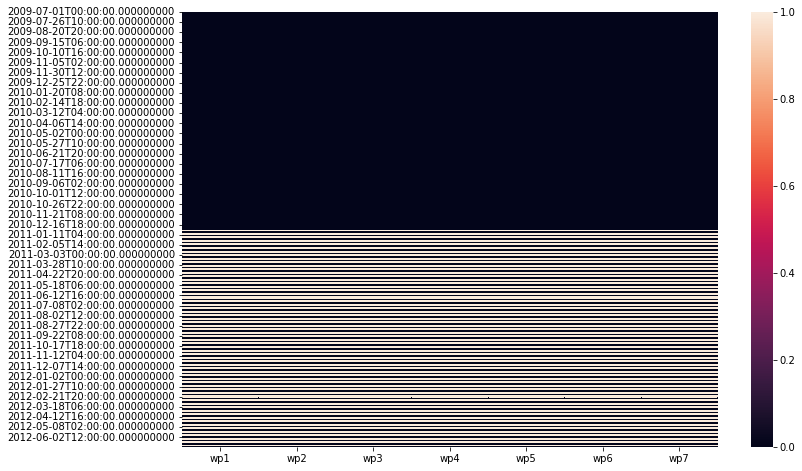

In [6]:
# Plot heatmap of missing data
ALL_TIME =  pd.DataFrame(index=pd.date_range(y_train.index[0],y_train.index[-1], freq='H')) 
plt.figure(figsize = (12,8))
sns.heatmap(y_train.join(ALL_TIME, how = 'outer').isna())  #['2011-06-01':'2011-06-04']

In [7]:
# Select forecast data set
x_train_update = x_train[x_train.hors<=12]
x_train_update.index = pd.to_datetime(x_train_update.index, format= '%Y%m%d%H')
x_train_update = x_train_update[:'2010-12-31 12']
x_train_update['time'] = x_train_update.index + pd.to_timedelta(x_train_update.hors,"H")

maxi=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.max()
mini=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.min()
x_train_update.ws=(x_train_update.ws-mini)/(maxi-mini)

# One hot encode the wind directions
wd_onehot = []

for i in range(len(x_train_update)):
  onehot = 12*[None]
  sector = np.floor(x_train_update.wd[i]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd_onehot.append(onehot)
  
  
x_train_sectors = pd.DataFrame(np.concatenate((np.reshape(x_train_update.ws.values,(len(x_train_update),1)),
                                              wd_onehot,
                                              np.cos(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.sin(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.cos(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365),
                                              np.sin(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365)),
                                            axis = 1),
            columns = 'ws s1 s2 s3 s4 s5 s6 s7 s8 s9 s10 s11 s12 time_day_cos time_day_sin time_year_cos time_year_sin'.split())
x_train_sectors.drop('s12',axis=1, inplace=True)

In [8]:
# Use only the power time series when continuous
complete_ts = y_train[:'2011-01-01 00'] # all the data without any gaps
input_generator = np.transpose(np.array([complete_ts.wp1]))
length = 36 # length of the time series, PARAMETER TO TUNE

In [9]:
# define validation and training set

batch_size = 128
# input_generator = np.transpose(np.array([y_train.wp1]))

# Note: TimeseriesGenerator end_index is including that index, not excluding it as it is the case in general in Python

training_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = 0 , end_index = int(len(complete_ts)*0.8)) # 80 percent
validation_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = int(len(complete_ts)*0.8)+1, end_index = len(complete_ts)-1)

In [10]:
print(f'The lenght of the validation set: {len(validation_set)}')
print(f'The lenght of the training set: {len(training_set)}')

The lenght of the validation set: 21
The lenght of the training set: 83


**Creation of LSTM architecture**

In [11]:
class FFNN_LSTM(nn.Module):
    def __init__(self):
        super(FFNN_LSTM, self).__init__()
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # batch_first = False >>> input prov (seq, batch, feature)

        self.lstm = nn.LSTM(input_size = 1, 
                  hidden_size = 32,#1028,
                     num_layers = 1,
                         batch_first = False)
        

        self.inputLay = nn.Linear(in_features = 16,
                               out_features = 32,#512,
                               bias = True)
        
        self.hidden_layer = nn.Linear(in_features = 32,#512,
                                      out_features = 32,#,512,
                                      bias = True)
        
        self.combined = nn.Linear(in_features= 32+32,#1028+512, 
                        out_features= 32,#512,
                        bias = True) # should be false ?

        self.output_lay = nn.Linear(in_features= 32,#512, 
                        out_features= 1,
                        bias = True) # should be false ?

                 
    def forward(self, pow_seq, for_feat):
        #print(np.shape(x))
        x = torch.permute(pow_seq, (1,0,2) )  # permute batch with sequence 
        #print(np.shape(x))
        x, (h, c) = self.lstm(x)

        x = x[-1] # takes the last hidden state of LSTM
        #print(x)
        #print(np.shape(x))
        # Dense layer
        y = self.inputLay(for_feat)
        y = F.elu(y) # F = nn.Functional
        y = self.hidden_layer(y)
        y = F.elu(y)
        #print(y)
        #print(np.shape(y))
        z = torch.cat( (x,y), dim = 1 )
        #print(np.shape(z))
        z = self.combined(z)
        z = F.elu(z)
        z = self.output_lay(z)

        return z
  
net = FFNN_LSTM()
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

print(net)


##converting network to cuda-enabled
FFNN_LSTM(
  (lstm): LSTM(1, 32)
  (inputLay): Linear(in_features=16, out_features=32, bias=True)
  (hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (combined): Linear(in_features=64, out_features=32, bias=True)
  (output_lay): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
myObj = FFNN_LSTM()
pow_seq = torch.Tensor(np.array([[[0.3],[0.4],[0.6]],[[0.3],[0.4],[0.6]]]))
for_feat = torch.Tensor([np.ones(16), np.ones(16)])
myObj(pow_seq , for_feat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[-0.1163],
        [-0.1163]], grad_fn=<AddmmBackward0>)

# define early stopping class 

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

**Training of the LSTM**

In [14]:
# Train loop 
criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(),lr=5e-6) # , momentum=0.9

training_loss, validation_loss = [], []  # store loss for each epoch
num_epochs = 15000 # should be tuned

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=1000, verbose=True)

for i in range(num_epochs):
  # Track loss
  epoch_training_loss = 0
  epoch_validation_loss = 0
  net.eval() # EVALUATION mode -> dont use regularization methods
    
  # For each sentence in validation set
  for j,(inputs, targets) in enumerate(validation_set):

    # Convert input to tensor
    inputs_pow = torch.Tensor(inputs)

    # ADD (length-1) hours and not length because the first forecast (index 0) is already for the next hour after the first observation.
    # The forecast in index (length-1) is then after the length first observations.
    # A -1 was added because the training set of forecast has one less value.

    inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1+int(len(complete_ts)*0.8)+1-1):((j+1)*batch_size+length-1+int(len(complete_ts)*0.8)+1-1)].values)        
    # print('Inside training loop')
    # print(f'shape of input {np.shape(inputs)}')

    if len(inputs_pow) != batch_size:
      inputs_pred = inputs_pred[:len(inputs_pow)]

    # Convert target to tensor
    targets = torch.Tensor(targets)
    #print(targets)
    # print(f'shape of targets {np.shape(targets)}')

    #Convert targets and inputs to cuda
    if torch.cuda.is_available():
        inputs_pow = Variable(inputs_pow.cuda())
        inputs_pred = Variable(inputs_pred.cuda())
        targets = Variable(targets.cuda())

    # Evaluate the model
    outputs = net(inputs_pow,inputs_pred) 

    # print(f'shape of outputs {np.shape(outputs)}')
    #print(outputs)
    # Compute loss


    loss =  criterion(outputs,targets) 

    if torch.cuda.is_available():
      epoch_validation_loss += loss.cpu().detach().numpy()
    else:
      epoch_validation_loss += loss.detach().numpy() # suma el loss de cada batch, luego se reinicia para proxima epoch


  net.train()

  for j,(inputs, targets) in enumerate(training_set):

    # Convert input to tensor
    inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1):((j+1)*batch_size+length-1)].values)
    inputs_pow = torch.Tensor(inputs)
    # print('Inside training loop')
    # print(f'shape of input {np.shape(inputs)}')

    # Convert target to tensor
    targets = torch.Tensor(targets)
    #print(targets)
    # print(f'shape of targets {np.shape(targets)}')

    if len(inputs_pow) != batch_size:
      inputs_pred = inputs_pred[:len(inputs_pow)]

    #Convert targets and inputs to cuda
    if torch.cuda.is_available():
        inputs_pow = Variable(inputs_pow.cuda())
        inputs_pred = Variable(inputs_pred.cuda())
        targets = Variable(targets.cuda())

    # Evaluate the model
    outputs = net(inputs_pow,inputs_pred)      
    # print(f'shape of outputs {np.shape(outputs)}')
    #print(outputs)
    # Compute loss
    loss =  criterion(outputs,targets)

    optimizer.zero_grad() # zero the gradients
    loss.backward()       # calculate gradients for current step
    optimizer.step()      # update the weights 

    if torch.cuda.is_available():
      epoch_training_loss += loss.cpu().detach().numpy()
    else:
      epoch_training_loss += loss.detach().numpy()

        

  # Save loss for plot
  avg_train_loss=np.sqrt(epoch_training_loss/(len(training_set)))
  avg_valid_loss=np.sqrt(epoch_validation_loss/(len(validation_set)))
  training_loss.append(avg_train_loss)
  validation_loss.append(avg_valid_loss)       
  print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

  # early_stopping needs the validation loss to check if it has decresed, 
  # and if it has, it will make a checkpoint of the current model
  early_stopping(avg_valid_loss, net)
    
  if early_stopping.early_stop:
    print("Early stopping")
    break


Streaming output truncated to the last 5000 lines.
Epoch 1489, training loss: 0.0656913165495064, validation loss: 0.06827910309956249
Validation loss decreased (0.068280 --> 0.068279).  Saving model ...
Epoch 1490, training loss: 0.06569067965884011, validation loss: 0.06827829107201536
Validation loss decreased (0.068279 --> 0.068278).  Saving model ...
Epoch 1491, training loss: 0.06569004142751751, validation loss: 0.0682774852054043
Validation loss decreased (0.068278 --> 0.068277).  Saving model ...
Epoch 1492, training loss: 0.0656894082397205, validation loss: 0.0682766824349129
Validation loss decreased (0.068277 --> 0.068277).  Saving model ...
Epoch 1493, training loss: 0.06568877830201741, validation loss: 0.06827588483109534
Validation loss decreased (0.068277 --> 0.068276).  Saving model ...
Epoch 1494, training loss: 0.06568815003443029, validation loss: 0.06827509190696351
Validation loss decreased (0.068276 --> 0.068275).  Saving model ...
Epoch 1495, training loss: 0.

KeyboardInterrupt: ignored

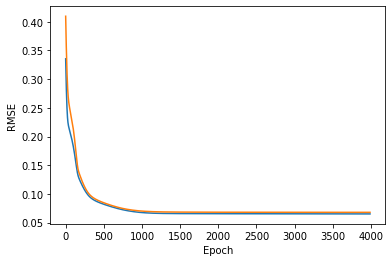

In [15]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, epoch, validation_loss)
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

**Evaluation of LSTM 1 to 6 hours ahead, on validation set**

In [16]:
# Define the validation set as one sequence
validation_power = input_generator[int(len(input_generator)*0.8)+1 : int(len(input_generator))-1]
validation_forecast_feats  = x_train_sectors.iloc[(length-1+int(len(complete_ts)*0.8)+1):len(x_train_sectors)]

In [17]:
# Define slices of 24h inputs and corresponding targets 1, 2 and 3 hours ahead
p_inputs = []
p_targets1h = []
p_targets2h = []
p_targets3h = []
p_targets4h = []
p_targets5h = []
p_targets6h = []

ff_inputs1h = []
ff_inputs2h = []
ff_inputs3h = []
ff_inputs4h = []
ff_inputs5h = []
ff_inputs6h = []

for i in range(len(validation_power)-(length+5)):
  ff_inputs1h.append(validation_forecast_feats.iloc[i].values)
  ff_inputs2h.append(validation_forecast_feats.iloc[i+1].values)
  ff_inputs3h.append(validation_forecast_feats.iloc[i+2].values)
  ff_inputs4h.append(validation_forecast_feats.iloc[i+3].values)
  ff_inputs5h.append(validation_forecast_feats.iloc[i+4].values)
  ff_inputs6h.append(validation_forecast_feats.iloc[i+5].values)


  p_inputs.append(validation_power[i:i+length])
  p_targets1h.append(validation_power[i+length])
  p_targets2h.append(validation_power[i+length+1])
  p_targets3h.append(validation_power[i+length+2])
  p_targets4h.append(validation_power[i+length+3])
  p_targets5h.append(validation_power[i+length+4])
  p_targets6h.append(validation_power[i+length+5])

In [18]:
# x_train_sectors["time"]=x_train_update.time.values   # JUST FOR TESTING THE DATE IS APPROPIATE, dont delete

In [19]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []
pred_4h = []
err_4h = []
pred_5h = []
err_5h = []
pred_6h = []
err_6h = []

# Loop over the sequences of valid data
for seq in range(len(p_inputs)):

    # Define past value for the 1h forecast
    past = p_inputs[seq]
    ff = ff_inputs1h[seq]

    # Take output for the past sequence
    pred_1h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_1h.append(pred_1h[-1]-p_targets1h[seq][0])

    # Repeat with prediction 2 hours ahead actualizing the past values
    past = np.append(past,[[pred_1h[-1]]],0)
    ff = ff_inputs2h[seq]
    pred_2h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_2h.append(pred_2h[-1]-p_targets2h[seq][0])

    # Repeat with prediction 3 hours ahead
    past = np.append(past,[[pred_2h[-1]]],0)
    ff = ff_inputs3h[seq]
    pred_3h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_3h.append(pred_3h[-1]-p_targets3h[seq][0])

    # Repeat with prediction 4 hours ahead
    past = np.append(past,[[pred_3h[-1]]],0)
    ff = ff_inputs4h[seq]
    pred_4h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_4h.append(pred_4h[-1]-p_targets4h[seq][0])

    # Repeat with prediction 5 hours ahead
    past = np.append(past,[[pred_4h[-1]]],0)
    ff = ff_inputs5h[seq]
    pred_5h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_5h.append(pred_5h[-1]-p_targets5h[seq][0])

    # Repeat with prediction 6 hours ahead
    past = np.append(past,[[pred_5h[-1]]],0)
    ff = ff_inputs6h[seq]
    pred_6h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_6h.append(pred_6h[-1]-p_targets6h[seq][0])

    if seq % 100 == 0:
      print(f'step {seq+1}, RMSE 1h: {np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))}, RMSE 2h: {np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))}, RMSE 3h: {np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))}, RMSE 4h: {np.sqrt(stat.mean(err_4h[n]**2 for n in range(len(err_4h))))}, RMSE 5h: {np.sqrt(stat.mean(err_5h[n]**2 for n in range(len(err_5h))))}, RMSE 6h: {np.sqrt(stat.mean(err_6h[n]**2 for n in range(len(err_6h))))}')

step 1, RMSE 1h: 0.026459113121032718, RMSE 2h: 0.0613124451637268, RMSE 3h: 0.0763649461269379, RMSE 4h: 0.1202839956283569, RMSE 5h: 0.1904716594219208, RMSE 6h: 0.08846376156806945
step 101, RMSE 1h: 0.056713574504506946, RMSE 2h: 0.08575909812177014, RMSE 3h: 0.09667046991456699, RMSE 4h: 0.10055150889603934, RMSE 5h: 0.10404085011969813, RMSE 6h: 0.10733578935845717
step 201, RMSE 1h: 0.0635337280233174, RMSE 2h: 0.0918012905852866, RMSE 3h: 0.10415464491166039, RMSE 4h: 0.10749238061165413, RMSE 5h: 0.1105147014450537, RMSE 6h: 0.1140147729120449
step 301, RMSE 1h: 0.06607457579162052, RMSE 2h: 0.09644233022564147, RMSE 3h: 0.11032564032171566, RMSE 4h: 0.11581279440946174, RMSE 5h: 0.11907671451860952, RMSE 6h: 0.12268816277959618
step 401, RMSE 1h: 0.06439380616991146, RMSE 2h: 0.09539212163988997, RMSE 3h: 0.11093538321478312, RMSE 4h: 0.11824898421529628, RMSE 5h: 0.12281319811427897, RMSE 6h: 0.12666740620234115
step 501, RMSE 1h: 0.06238309131937559, RMSE 2h: 0.092364746159

In [ ]:
# Estimation of confidence intervals:
RMSE_1h = np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))
RMSE_2h = np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))
RMSE_3h = np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))
CI_1h = [norm.ppf(0.025)*RMSE_1h,norm.ppf(0.975)*RMSE_1h]
CI_2h = [norm.ppf(0.025)*RMSE_2h,norm.ppf(0.975)*RMSE_2h]
CI_3h = [norm.ppf(0.025)*RMSE_3h,norm.ppf(0.975)*RMSE_3h]
print(f'Confidence interval 1h: {CI_1h}')
print(f'Confidence interval 2h: {CI_2h}')
print(f'Confidence interval 3h: {CI_3h}')